In [33]:
import sys
import os
from pathlib import Path
# Get the current working directory (where the notebook/script is running)
current_dir = Path(os.getcwd())
# Navigate to the 'main' folder (adjust if needed)
main_dir = str(current_dir.parent)  # If notebook is inside 'main'
# OR if notebook is outside 'main':
# main_dir = str(current_dir / "main")  # Assumes 'main' is a subfolder
sys.path.append(main_dir)
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning and Clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# import the split lib to split the data into train and test
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [95]:
data_org = pd.read_csv('C:/Users/yoonus/Documents/GitHub/Stock_AI_Predictor/Data/Stocks/BTCUSD60.csv')
data_org['Date'] = data_org['Date'].astype('datetime64[s]')
data_org = data_org.set_index('Date')

data = data_org.loc['2018-01-01':'2018-12-28']
test_data = data_org.loc['2019-01-01':'2019-03-28']

print(data.tail(1))
print(test_data.head(1))

             Time     Open     High      Low    Close  Volume
Date                                                         
2018-12-28  22:00  3867.99  3895.99  3858.99  3889.24       0
             Time    Open     High      Low    Close  Volume
Date                                                        
2019-01-02  00:00  3750.2  3875.24  3706.14  3716.64       0


In [100]:

def create_sequences(data, window_size=5, forecast_horizon=5):
    X = []
    y = []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)


arr = data['Close'].to_numpy()
scaler_train = MinMaxScaler()
arr_scaled = scaler_train.fit_transform(arr.reshape(-1, 1)).flatten()

# Create sequences
X, y = create_sequences(arr_scaled, window_size=5, forecast_horizon=1)

# Reshape X to fit LSTM input: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape, y.shape)

(6135, 5, 1) (6135, 1)


Epoch 1/20


c:\Users\yoonus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0326 - mae: 0.1056 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9853e-04 - mae: 0.0099 - val_loss: 8.2020e-04 - val_mae: 0.0231
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7494e-04 - mae: 0.0088 - val_loss: 4.3678e-04 - val_mae: 0.0156
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7515e-04 - mae: 0.0086 - val_loss: 3.9876e-04 - val_mae: 0.0165
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6870e-04 - mae: 0.0085 - val_loss: 3.5772e-04 - val_mae: 0.0154
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5491e-04 - mae: 0.0080 - val_loss: 3.6412e-04 - val_mae: 0.0164
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7525e-04 - mae: 0.0087 - val_loss: 2.1544e-04 - val_mae: 0.0112
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6516e-04 - mae: 0.0085 - val_loss: 1.7003e-04 - val_mae: 0.0102
Epoch 9/20


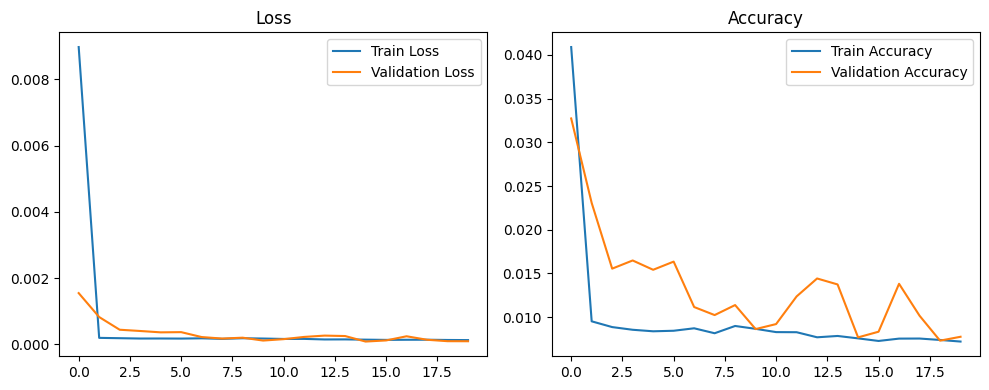

In [101]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(5))  # Output a single price value
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MAE or MSE for regression

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train Accuracy')
plt.plot(history.history['val_mae'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()


# Predict using x_val

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(1227, 5, 1) (1227, 5)
(1227, 1) (1227, 5)


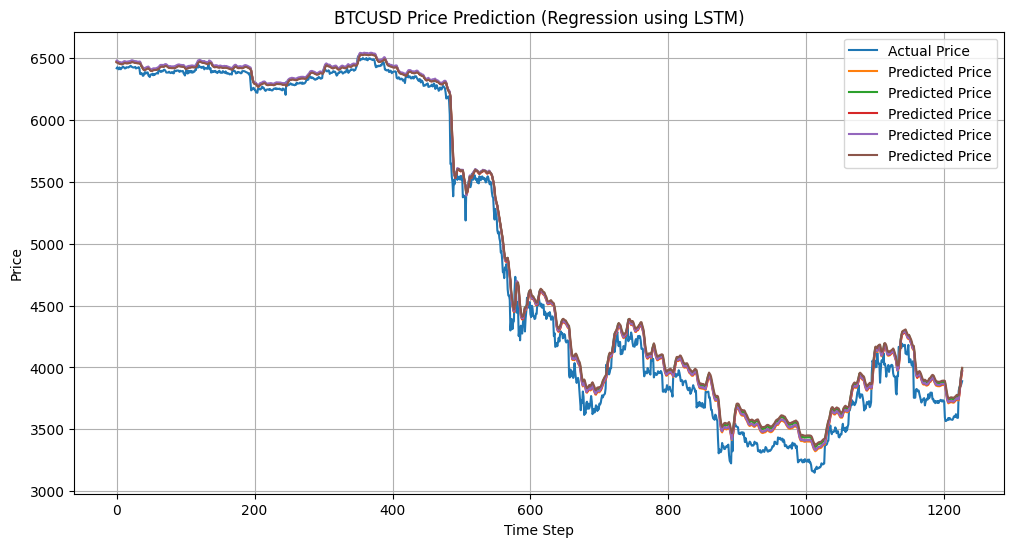

In [103]:

y_pred = model.predict(X_val)
print(X_val.shape, y_pred.shape)

# Undo scaling if needed
y_pred_inv = scaler_train.inverse_transform(y_pred)
y_val_inv =  scaler_train.inverse_transform(y_val.reshape(-1, 1))

# reshape the y_pred_inv to be the same shape as y_val_inv
#y_pred_inv = y_pred_inv.reshape(-1, 1)
print(y_val_inv.shape, y_pred_inv.shape)
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price') # get the fifth value of the prediction by using y_pred_inv[:, 4]
plt.title('BTCUSD Price Prediction (Regression using LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Predict using future data

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1488,) (7415, 1)


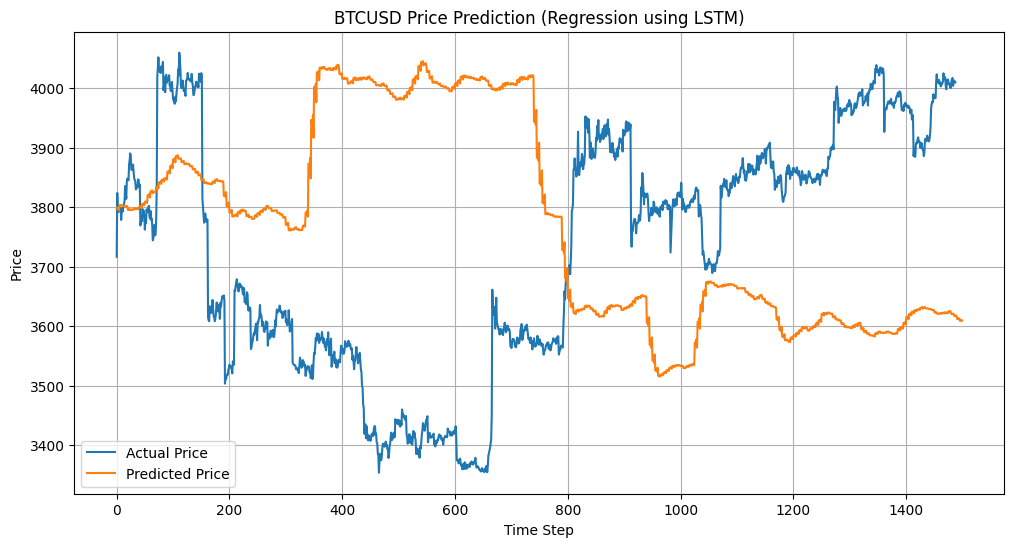

In [106]:
# prepere the test data
test_arr = test_data['Close'].to_numpy()
scaler_test = MinMaxScaler()
arr__test_scaled = scaler_test.fit_transform(test_arr.reshape(-1, 1)).flatten()

arr_test_scaled_sequences, _ = create_sequences(arr__test_scaled, window_size=5, forecast_horizon=1)


arr_test_scaled_sequences= arr_test_scaled_sequences.reshape((arr_test_scaled_sequences.shape[0], arr_test_scaled_sequences.shape[1], 1))

y_pred = model.predict(arr_test_scaled_sequences)
y_pred = y_pred.reshape(-1, 1)
print(test_arr.shape, y_pred.shape)

# Undo scaling if needed
y_pred_inv = scaler_test.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(test_arr, label='Actual Price')
plt.plot(y_pred_inv[0:1500], label='Predicted Price')
plt.title('BTCUSD Price Prediction (Regression using LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
